In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [ ]:
import numpy as np
import tensorflow as tf
import random as rn
import os
import json

from keras import metrics, regularizers, optimizers, backend
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import Model
from keras.layers import Input, Dense, LSTM, CuDNNLSTM, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, vis_utils

import scipy.io as sio

# fix random seed
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(2018)
rn.seed(2018)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=4)
tf.set_random_seed(2018)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
backend.set_session(sess)

seqLen = 128
nClass = 4
samNum = 100000 * nClass
# load train data
x_data_mat = sio.loadmat('/content/drive/My Drive/train_data_awgn_100k.mat')
x_data_complex = x_data_mat['train_data']
x_data_real = x_data_complex.real
x_data_imag = x_data_complex.imag
x_data_real = x_data_real.reshape((x_data_real.shape[0], seqLen))
x_data_imag = x_data_imag.reshape((x_data_imag.shape[0], seqLen))
x_train = np.stack((x_data_real, x_data_imag), axis=2)
y_data_mat = sio.loadmat('/content/drive/My Drive/train_label_awgn_100k.mat')
y_data = y_data_mat['train_label'][:,0]
y_snrs = y_data_mat['train_label'][:,1]
y_train = np_utils.to_categorical(y_data, nClass)
# train data shuffle
index = np.arange(y_train.shape[0])
np.random.shuffle(index)
x_train = x_train[index,:]
y_train = y_train[index]

_in_ = Input(shape = (x_train.shape[1], x_train.shape[2]))
ot = CuDNNLSTM(16, return_sequences=False)(_in_)
#ot = Flatten()(ot)
ot = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True)(ot)
ot = Dense(64, use_bias=True, activation='relu')(ot)
ot = Dense(16, use_bias=True, activation='relu')(ot)
_out_ = Dense(nClass, activation='softmax')(ot)
model = Model(_in_, _out_)

tensor_board = TensorBoard(log_dir='./tensorboard_log', histogram_freq=0, write_graph=True, write_images=False,
                            embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy',
               optimizer=adam, 
               metrics=['categorical_accuracy'])
model.fit(x_train,
          y_train, 
          epochs=100, 
          batch_size=128,
          validation_split=0.1,
          shuffle=True,callbacks=[early_stopping])
          #callbacks=[])
          #callbacks=[tensor_board])
          #callbacks=[early_stopping])
          #callbacks=[tensor_board, early_stopping])
model.summary()



Train on 360000 samples, validate on 40000 samples
Epoch 1/100
360000/360000 [==============================] - 39s 108us/step - loss: 0.6170 - categorical_accuracy: 0.6561 - val_loss: 0.4683 - val_categorical_accuracy: 0.7419
Epoch 2/100
360000/360000 [==============================] - 38s 107us/step - loss: 0.4615 - categorical_accuracy: 0.7554 - val_loss: 0.4499 - val_categorical_accuracy: 0.7629
Epoch 3/100
360000/360000 [==============================] - 38s 107us/step - loss: 0.4442 - categorical_accuracy: 0.7658 - val_loss: 0.4338 - val_categorical_accuracy: 0.7713
Epoch 4/100
360000/360000 [==============================] - 38s 107us/step - loss: 0.4337 - categorical_accuracy: 0.7714 - val_loss: 0.4223 - val_categorical_accuracy: 0.7797
Epoch 5/100
360000/360000 [==============================] - 39s 108us/step - loss: 0.4246 - categorical_accuracy: 0.7775 - val_loss: 0.4428 - val_categorical_accuracy: 0.7682
Epoch 6/100
360000/360000 [==============================] - 39s 108u

In [ ]:
model.save_weights('/content/drive/My Drive/model_weights_rnn_lite_awgn.h5')

In [ ]:
acc_array_cumulants_awgn=[0.247500,0.247500,0.267500,0.242500,0.260000,0.315000,0.457500,0.632500,0.845000,0.950000,0.985000,1.000000,1.000000,1.000000,1.000000,1.000000]

In [ ]:
X_test_mat=sio.loadmat('/content/drive/My Drive/train_data_awgn_10k.mat')
Y_test_mat=sio.loadmat('/content/drive/My Drive/train_label_awgn_10k.mat')
X_test_complex = X_test_mat['train_data']
X_test_real = X_test_complex.real
X_test_imag = X_test_complex.imag
X_test_real = X_test_real.reshape((X_test_real.shape[0], seqLen))
X_test_imag = X_test_imag.reshape((X_test_imag.shape[0], seqLen))
X_test = np.stack((X_test_real, X_test_imag), axis=2)

In [ ]:
fucked=Y_test_mat['train_label']
Y_test=fucked[:,0]
Y_test_snrs=fucked[:,1]
Y_test=np_utils.to_categorical(Y_test,4)
score = model.evaluate(X_test, Y_test,  verbose=0)
print(score)
#test_Y_hat = model.predict(X_test)

[0.38159793635606765, 0.8]


In [ ]:
acc_array_cumulants_rayleigh=[0.2500, 0.2458 ,   0.2542  ,  0.2833  ,  0.3167  ,  0.3958  ,  0.4125   , 0.5875  ,  0.6792 ,   0.7458  ,  0.8167 ,   0.8750,  0.9417 ,   0.9375 ,   0.9708 ,   0.9625]

In [ ]:
snrs=np.arange(-10,21,2)

In [ ]:

acc_lstm_awgn = {}
for snr in snrs:
    # extract classes @ SNR
    #test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(Y_test_snrs)==snr)]
    test_Y_i = Y_test[np.where(np.array(Y_test_snrs)==snr)]  
    test_Y_i_hat = model.predict(test_X_i.reshape(test_X_i.shape[0],128,2))
    conf = np.zeros([4,4])
    confnorm = np.zeros([4,4])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,4):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    print("snr=",snr)
    acc_lstm_awgn[snr] = 1.0*cor/(cor+ncor)

Overall Accuracy:  0.3460434604346043
snr= -10
Overall Accuracy:  0.3839249286005712
snr= -8
Overall Accuracy:  0.44208037825059104
snr= -6
Overall Accuracy:  0.5149130074565037
snr= -4
Overall Accuracy:  0.6153232242617718
snr= -2
Overall Accuracy:  0.7004698512137824
snr= 0
Overall Accuracy:  0.8527755430410298
snr= 2
Overall Accuracy:  0.9338205440519691
snr= 4
Overall Accuracy:  0.9813046937151949
snr= 6
Overall Accuracy:  0.9988175009854159
snr= 8
Overall Accuracy:  1.0
snr= 10
Overall Accuracy:  1.0
snr= 12
Overall Accuracy:  1.0
snr= 14
Overall Accuracy:  1.0
snr= 16
Overall Accuracy:  1.0
snr= 18
Overall Accuracy:  1.0
snr= 20


In [ ]:
import matplotlib.pyplot as plt

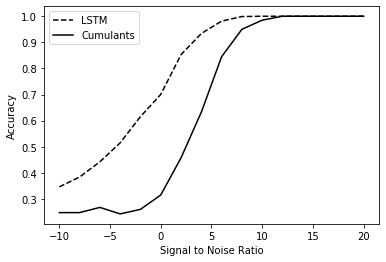

In [ ]:
plt.plot(snrs, list(map(lambda x: acc_lstm_awgn[x], snrs)),'k--',label='LSTM')
plt.plot(snrs, acc_array_cumulants_awgn,'k-',label='Cumulants')
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/My Drive/lstm_vs_cum_awgn.png',figsize=(15,7.5), dpi= 100)	#save image

In [ ]:
list(map(lambda x: acc_lstm_awgn[x], snrs))

[0.3460434604346043,
 0.3839249286005712,
 0.44208037825059104,
 0.5149130074565037,
 0.6153232242617718,
 0.7004698512137824,
 0.8527755430410298,
 0.9338205440519691,
 0.9813046937151949,
 0.9988175009854159,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
list(map(lambda x: acc_lstm_rayleigh[x], snrs))

[0.2826534816646065,
 0.3249370277078086,
 0.3669579030976966,
 0.4213217938630999,
 0.47513812154696133,
 0.5663430420711975,
 0.6441368078175895,
 0.7141104294478527,
 0.7864,
 0.8565815324165029,
 0.8978790259230165,
 0.9360675512665863,
 0.9613259668508287,
 0.9721459395841506,
 0.9842368319876971,
 0.991876523151909]

In [ ]:
acc_array_cumulants_awgn

[0.2475,
 0.2475,
 0.2675,
 0.2425,
 0.26,
 0.315,
 0.4575,
 0.6325,
 0.845,
 0.95,
 0.985,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
acc_array_cumulants_rayleigh

[0.25,
 0.2458,
 0.2542,
 0.2833,
 0.3167,
 0.3958,
 0.4125,
 0.5875,
 0.6792,
 0.7458,
 0.8167,
 0.875,
 0.9417,
 0.9375,
 0.9708,
 0.9625]